In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score


In [54]:
df =pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## EDA

In [31]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [55]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [56]:
numerical_columns = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']
categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']

In [ ]:
# df[categorical_columns] = df[categorical_columns].fillna('NA')
# df[numerical_columns] = df[numerical_columns].fillna(0)


In [57]:
# Testing the code with mean fillna so getting correct answers in questions
mean = round(df['annual_income'].mean() , 1)
df[categorical_columns] = df[categorical_columns].fillna('NA')
df[numerical_columns] = df[numerical_columns].fillna(mean)
mean

np.float64(59886.3)

In [58]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [59]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [60]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [61]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance

In [63]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

for col in numerical_columns:
    AUC = roc_auc_score(y_train, df_train[col])
    if AUC < 0.5: # all values are above .5
        AUC = roc_auc_score(y_train, -df_train[col])
    print(f'{col}: {AUC}')

number_of_courses_viewed: 0.7635680590007088
annual_income: 0.5581923281360738
interaction_count: 0.738270176293409
lead_score: 0.6144993577250176


### One Hot Encoding

In [64]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [65]:
X_train.shape

(876, 31)

### Question 2 Train the model - logistic regression


In [66]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

AUC = round(roc_auc_score(y_val, y_pred), 3)
print(f'Model AUC Score: {AUC}')

# Answer: 0.92 Selected which is close to my answer

Model AUC Score: 0.825


### Question 3: Precision and Recall

In [67]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [ ]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.4, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

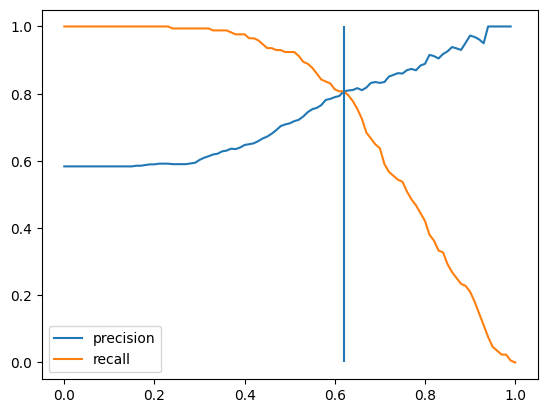

In [73]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')

plt.vlines(0.62, 0, 1)
plt.legend()
plt.show()

### Question 4: F1 score

In [74]:
df_scores['f1'] = 2 * ((df_scores['precision'] * df_scores['recall'])/  (df_scores['precision'] + df_scores['recall']))

df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.0,171,122,0,0,0.583618,1.000000,0.737069
10,0.1,171,122,0,0,0.583618,1.000000,0.737069
20,0.2,171,119,0,3,0.589655,1.000000,0.741866
30,0.3,170,112,1,10,0.602837,0.994152,0.750552
40,0.4,167,91,4,31,0.647287,0.976608,0.778555
50,0.5,158,64,13,58,0.711712,0.923977,0.804071
60,0.6,139,37,32,85,0.789773,0.812865,0.801153
70,0.7,109,22,62,100,0.832061,0.637427,0.721854
80,0.8,72,9,99,113,0.888889,0.421053,0.571429
90,0.9,36,1,135,121,0.972973,0.210526,0.346154


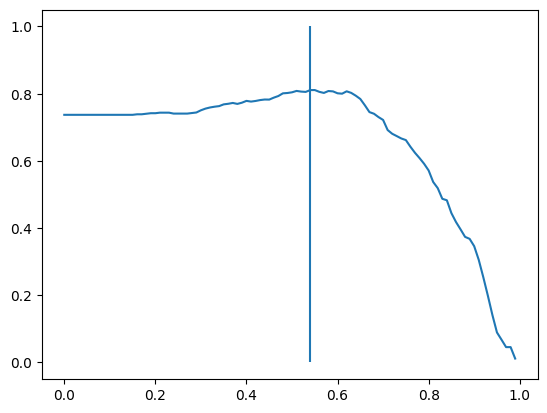

In [79]:
plt.Figure(figsize=(6,6))
plt.plot(df_scores.threshold , df_scores.f1)
plt.vlines(0.54, 0, 1)
plt.show()

### Question 5: 5-Fold CV

In [80]:
!pip install tqdm

In [81]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [82]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [83]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [86]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % ( np.mean(scores), np.std(scores)))

0.834 +- 0.034


### Question 6: Hyperparameter Tuning

In [88]:
n_splits = 5

for c in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.565 +- 0.019
C=0.001 0.871 +- 0.028
C=1 0.834 +- 0.034
